<a href="https://colab.research.google.com/github/yrsheld/Practice/blob/main/fcc_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [3]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [8]:
df.columns = dataset_cols
df['functional'] = (df['functional']=='Yes').astype(int)
df = df[df['hour']==12]   #only take data where hour = 12
df = df.drop(["hour"], axis=1)

In [9]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


# Plot features vs. bike count
Get a rough idea of which features may be useful.

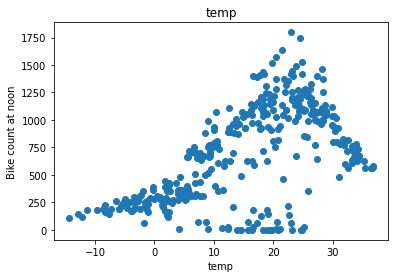

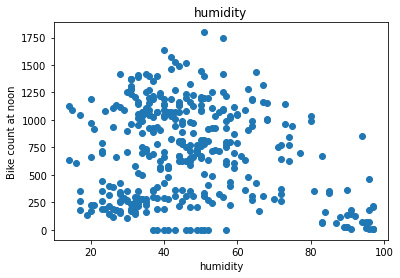

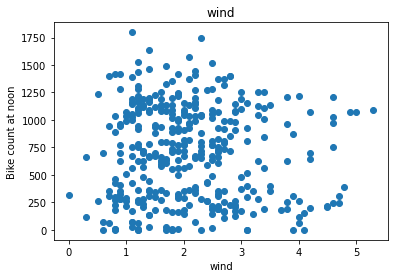

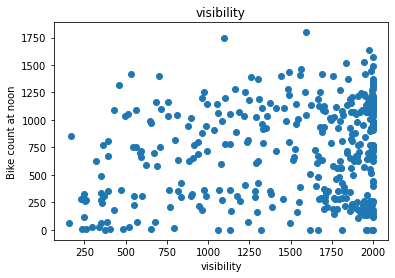

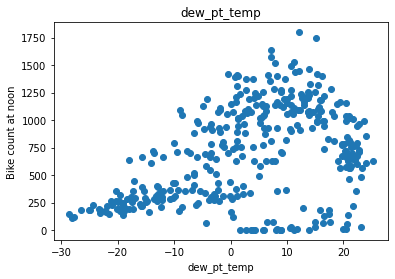

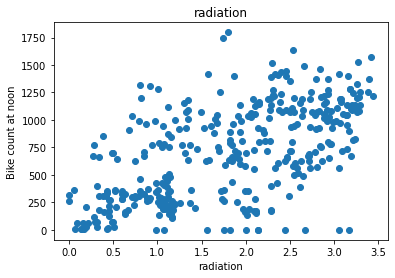

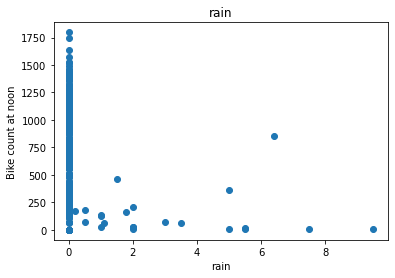

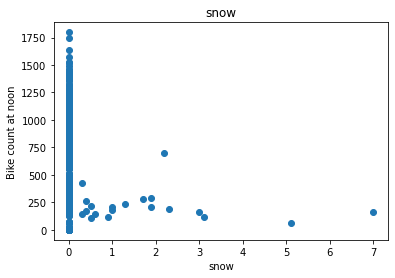

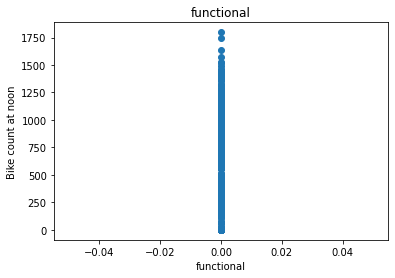

In [10]:
# except bike_count
for label in df.columns[1:]:  
  plt.scatter(df[label], df['bike_count'])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel('Bike count at noon')
  plt.show()

In [11]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)

In [12]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/valid/test dataset

In [13]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [14]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if not x_labels:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X, y))

  return data, X, y

# Linear Regression
Using only a single feature: temperaure

In [15]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [16]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [17]:
print(temp_reg.coef_, temp_reg.intercept_)    # parameters of the line

[[20.38875629]] [384.92112448]


### Testing
Test the simple regressor on test data, and get the R2 score

In [18]:
temp_reg.score(X_test_temp, y_test_temp)

0.3330833002430488

### Plot result

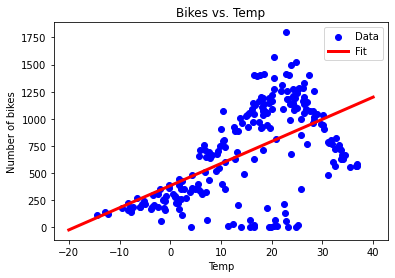

In [19]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs. Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression
Use all features

In [23]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count")
_, X_val_all, y_val_all = get_xy(val, "bike_count")
_, X_test_all, y_test_all = get_xy(test, "bike_count")

In [24]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [25]:
all_reg.score(X_test_all, y_test_all)

0.5526443941428341

In [62]:
y_pred_lr = all_reg.predict(X_test_all)

# Regression with Neural Net

In [48]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss') #validation loww
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.grid(True)
  plt.legend()
  plt.show()

## Single perceptron
Single perceptron with single feature

In [40]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))  #reshape into a single vector

In [42]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,                   # normalization layr
    tf.keras.layers.Dense(1)           # one single perceptron
])

In [50]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.11), loss='mean_squared_error')

In [51]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp, 
    epochs=1000, 
    verbose=0,
    validation_data=(X_val_temp, y_val_temp)
)

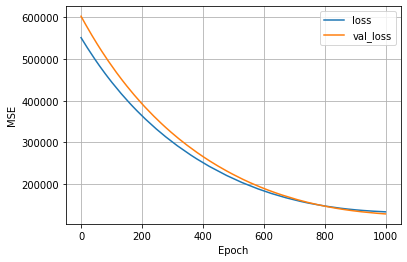

In [52]:
plot_loss(history)

### Plot result

4/4 [==============================] - 0s 4ms/step


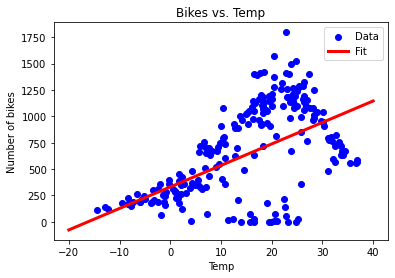

In [53]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs. Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

## Neural net
Neural net with all features used

In [67]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)   # 6 features
all_normalizer.adapt(X_train_all)

In [68]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [69]:
history = nn_model.fit(
    X_train_all, y_train_all,
    verbose = 0,
    epochs=1000,
    validation_data = (X_val_all, y_val_all)
)

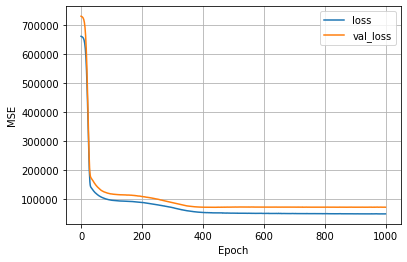

In [73]:
plot_loss(history)

In [70]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 4ms/step


In [71]:
def MSE(y_pred, y_real):
  return (np.square(y_pred-y_real)).mean()

In [72]:
print(MSE(y_pred_lr, y_test_all))
print(MSE(y_pred_nn, y_test_all))

93779.68687487951
88547.40483023917


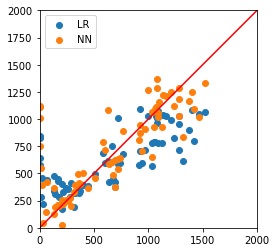

In [76]:
ax = plt.axes(aspect="equal")
lim = [0, 2000]
plt.scatter(y_test_all, y_pred_lr, label='LR')
plt.scatter(y_test_all, y_pred_nn, label='NN')
plt.xlim(lim)
plt.ylim(lim)
plt.legend()
plt.plot(lim, lim, c="red")